<img src="http://www.exalumnos.usm.cl/wp-content/uploads/2015/06/MARCA-Color.jpg" title="Title text" width="50%" height="50%" />


<hr style="height:2px;border:none"/>
<h1 align='center'> INF-395/477 Redes Neuronales Artificiales II-2018 </h1>

<H3 align='center'> Tarea 3 - Redes Recurrentes y Autoencoders </H3>
<hr style="height:2px;border:none"/>



**Temas**  
* Diseño e implementación de Redes Neuronales Recurrentes (RNN).
* Regularización en Redes Recurrentes.
* Autoencoders tradicionales y sus aplicaciones

** Formalidades **  
* Equipos de trabajo de: 2 personas (*cada uno debe estar en condiciones de realizar una presentación y discutir sobre cada punto del trabajo realizado*)
* Se debe preparar una presentación de 20 minutos. Presentador será elegido aleatoriamente.
* Se debe preparar un (breve) Jupyter/IPython notebook que explique la actividad realizada y las conclusiones del trabajo
* Fecha de entrega y discusión: 21 de Diciembre (sin posibilidad de extensiones)
* Formato de entrega: envı́o de link Github al correo electrónico del ayudante (*<margarita.bugueno.13@sansano.usm.cl>*) , incluyendo al profesor en copia (*<cvalle@inf.utfsm.cl>*). Por favor especificar el siguiente asunto: [Tarea3-INF395-II-2018] 

<hr style="height:2px;border:none"/>

La tarea se divide en dos secciones:

[1.](#primero) RNN sobre texto    
[2.](#segundo) Autoencoder en MNIST  


### **Nota Importante:**  
Para esta actividad **si es que no se cuenta con GPU** se recomienda utilizar el entorno virtual de __[Colaboratory - Google](https://colab.research.google.com/)__* . Así, podrá programar en la nube con recursos elevados y luego descargar el Jupyter Notebook y entregarlo en modo Informe. 


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
import seaborn as sns
import matplotlib.cm as cm
import os   
import keras as krs
import math
import h5py
import pickle
import getpass

from keras import utils as np_utils
from keras import backend as bknd

from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Input, Flatten, Dropout, Conv2D, MaxPooling2D
from keras.datasets import cifar10, mnist
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD, Adam, RMSprop, Adagrad, Adadelta, rmsprop
from keras.layers.core import Dense, Activation
from keras.regularizers import l1,l2
from keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import StandardScaler

from google.colab import files

Using TensorFlow backend.


In [0]:
from google.colab import drive
import pickle

drive.mount('/content/drive', force_remount=True)
DATA_PATH = "/content/drive/My Drive/Colab Tarea 3/Models/"

In [0]:
def Repartir_Conjuntos(Train,Test,x,y):
  print("This function splits the framework this way:\n Train from 0% to (First parameter)%\n Test from (First parameter)% to (First+Second parameter)%\n Validation will be the rest.")
  if (0<Train<1) == False:
    print("ERROR: First parameter must be type float between 0 and 1")
    return
  if (0<Test<1) == False:
    print("ERROR: Second parameter must be type float between 0 and 1")
    return
  if (Train+Test<1) == False:
    print("ERROR: First parameter plus Second parameter can't be bigger than one")
    return
  
  largo = len(x);
  Train=int(Train*largo);
  Test = int(Test*largo + Train);
  (x_train, y_train)=x[0:Train],y[0:Train];
  (x_test, y_test)=x[Train:Test],y[Train:Test];
  (x_val, y_val)=x[Test:],y[Test:];
  return((x_train, y_train),(x_test, y_test),(x_val, y_val))

<a id="segundo"></a>
## 2. Autoencoders (AEs) en MNIST


Como se ha discutido en clases, las RBM’s y posteriormente los AE’s (redes no supervisadas) fueron un componente crucial en el desarrollo de los modelos que entre 2006 y 2010 vigorizaron el área de las redes neuronales artificiales con logros notables de desempeño en diferentes tareas de aprendizaje automático. En esta sección aprenderemos a utilizar el más sencillo de estos modelos: un autoencoder o AE. Consideraremos tres aplicaciones clásicas: reducción de dimensionalidad, *denoising* y pre-entrenamiento. Con este objetivo en mente, utilizaremos un dataset denominado MNIST[[3]](#refs). Se trata de una colección de 70000 imágenes de 28 $\times$ 28 pixeles correspondientes a dígitos manuscritos (números entre 0 y 9). En su versión tradicional, la colección se encuentra separada en dos subconjuntos: uno de entrenamiento de 60000 imágenes y otro de test de 10000 imágenes. La tarea consiste en construir un programa para que aprenda a identificar correctamente el dı́gito representado en la imagen


> a) Escriba el código que **cargue los datos** desde el repositorio de keras, normalice las imágenes de modo que los pixeles queden en [0, 1], transforme las imágenes en vectores ($\in {\rm I\!R}^{784}$) y devuelva tres subconjuntos disjuntos: uno de entrenamiento, uno de validación y uno de pruebas. Construya el conjunto de validación de la manera que estime conveniente, éste debe contar con $nval = 5000$ imágenes.

In [70]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x = np.concatenate((x_train,x_test), axis=0);
x = x.astype('float32') / 255.
y = np.concatenate((y_train,y_test), axis=0);
[[x_train, y_train],[x_test, y_test],[x_val, y_val]]=Repartir_Conjuntos(0.5,0.3,x,y)
print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_vals's shape:  ",y_val.shape)

x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_val = x_val.reshape((len(x_val), np.prod(x_val.shape[1:])))

print("-----------------------------------")
print("x_train's shape: ",x_train.shape)
print("y_train's shape: ",y_train.shape)

print("x_test's shape:  ",x_test.shape)
print("y_test's shape:  ",y_test.shape)

print("x_val's shape:   ",x_val.shape)
print("y_val's shape:   ",y_val.shape)

This function splits the framework this way:
 Train from 0% to (First parameter)%
 Test from (First parameter)% to (First+Second parameter)%
 Validation will be the rest.
-----------------------------------
x_train's shape:  (35000, 28, 28)
y_train's shape:  (35000,)
x_test's shape:   (21000, 28, 28)
y_test's shape:   (21000,)
x_val's shape:    (14000, 28, 28)
y_vals's shape:   (14000,)
-----------------------------------
x_train's shape:  (35000, 784)
y_train's shape:  (35000,)
x_test's shape:   (21000, 784)
y_test's shape:   (21000,)
x_val's shape:    (14000, 784)
y_val's shape:    (14000,)


###Constantes y almacen de datos

In [0]:
n_epocs=40
#historias = {}

### 2.2 Denoising
Como se ha discutido en clases, un *denoising autoencoder* (dAE)[[4]](#refs) es escencialmente un autoencoder entrenado para reconstruir ejemplos parcialmente corruptos. Varios autores han demostrado que mediante esta modificación simple es posible obtener representaciones más robustas y significativas que aquellas obtenidas por un AE básico. En esta sección exploraremos la aplicación más “natural” o “directa” del método.





> a) **Genere artificialmente una versión corrupta de las imágenes en MNIST** utilizando el siguiente modelo de ruido (masking noise): si $ x \in {\rm I\!R}^d $ es una de las imágenes originales, la versión ruidosa $\tilde{x}$ se obtiene como $\tilde{x} = x \odot \xi$ donde $\odot$ denota el producto de Hadamard (componente a componente) y $\xi \in {\rm I\!R}^d$ es un vector aleatorio binario con componentes *Ber(p)* independientes.

In [0]:
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask

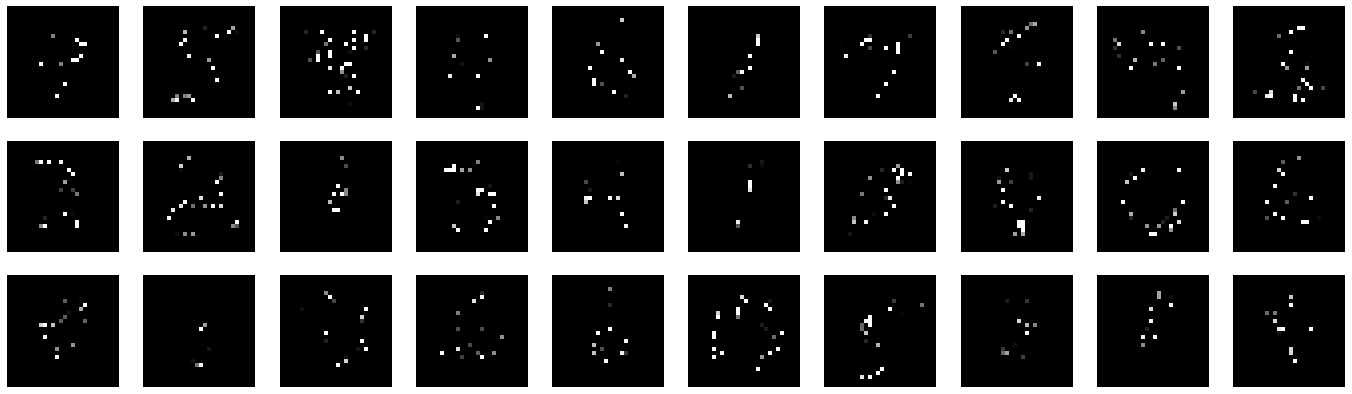

In [20]:
  import matplotlib.pyplot as plt
  n = 10
  plt.figure(figsize=(24, 7))
  for i in range(n):
      j = np.random.randint(0,len(x_val))
      ax = plt.subplot(3, n, i + 1)
      plt.imshow(noisy_x_train[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(3, n, i + 1 + 1*n)
      plt.imshow(noisy_x_test[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      ax = plt.subplot(3, n, i + 1 + 2*n)
      plt.imshow(noisy_x_val[j].reshape(28, 28),cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
  plt.show()

Se imprimen ejemplos de números de los tres conjuntos, x_train, x_test y x_val. 

> b) Entrene un autoencoder para reconstruir las imágenes corruptas generadas en el ı́tem anterior. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes. **Experimente diferentes valores de *p* en el rango (0, 1).**


In [75]:
d=64
from keras.models import load_model
formato = 'Activation: {0}\nLoss: {1}\nd={2}'

input_img = Input(shape=(784,))

encoded = Dense(d, activation='sigmoid')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input=input_img, output=decoded)

encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(d,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
autoencoder.fit(noisy_x_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)
autoencoder.save(DATA_PATH+'T3_P2_3_sigmoide_mse_d'+str(d)+'.h5')




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':


Train on 28000 samples, validate on 7000 samples
Epoch 1/50
28000/28000 [==============================] - 2s 80us/step - loss: 0.1946 - val_loss: 0.1607
Epoch 2/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.1396 - val_loss: 0.1215
Epoch 3/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.1109 - val_loss: 0.1010
Epoch 4/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0955 - val_loss: 0.0897
Epoch 5/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0869 - val_loss: 0.0831
Epoch 6/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0818 - val_loss: 0.0791
Epoch 7/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0785 - val_loss: 0.0764
Epoch 8/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0763 - val_loss: 0.0745
Epoch 9/50
28000/28000 [==============================] - 1s 23us/step - loss: 0.0747 - val_loss: 0.0732
Epoch 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_133 (InputLayer)       (None, 784)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_42 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


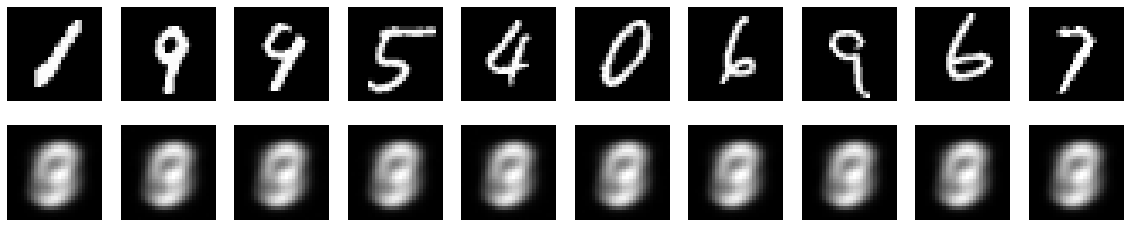

In [76]:
d=64
act = 'Relu'
losss = 'Mean Squared Error'
autoencoder.summary()
encoder = Model(autoencoder.input, autoencoder.layers[1].output)
decoder_input = Input(shape=(d,))
decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))

encoded_test = encoder.predict(noisy_x_test)
decoded_test = decoder.predict(encoded_test)

import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    j = np.random.randint(0,len(noisy_x_test))
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_test[j].reshape(28, 28),cmap='gray')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Se comprueba que una activación sigmoidal es algo menos sensible al ruido que una activación del tipo relu. Se estima que ha de ser por el caracter acotado de la función sigmoidal. La red es aún incapaz de regenerar los números, pero una pequeña mirada comprueba que esto no es fácil tampoco para el er humano, lo que hace sospechar de una eliminación excesiva del ruido.

> c) Utilice la representación reducida, genera por el *denoising AE*, para **medir el desempeño en clasificación** (vı́a kNN como en la sección anterior). Comente.



In [73]:
mod =load_model(DATA_PATH+'T3_P2_1_relu_mse_d64'+'.h5')
mod.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 64)                50240     
_________________________________________________________________
dense_48 (Dense)             (None, 784)               50960     
Total params: 101,200
Trainable params: 101,200
Non-trainable params: 0
_________________________________________________________________


In [0]:
mod.save(DATA_PATH+'T3_P2_1_relu_mse_d64')
pickle.dump(history,open(DATA_PATH+'history_322.p','wb'))

In [0]:

i='T3_P2_1_relu_mse_d64'

In [50]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
print('-------------------------------------------')
i='T3_P2_1_relu_mse_d64'
if i[-2]=='d':
  d=int(i[-1])
else:
  d=int(i[-2:])
act = 'Sigmoid'
if 'relu' in i:
  act = 'Relu'
losss = 'Mean Squared Error'
if '_bc_' in i:
  losss = 'Binary Crossentropy'

pca = PCA(n_components=d)
pca.fit(x_train)
pca_train = pca.transform(x_train)
pca_test = pca.transform(x_test)

...#AUTOENCODER

input_img = Input(shape=(784,))

encoded = Dense(64, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input=input_img, output=decoded)

autoencoder.summary
encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(d,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
hist2C = autoencoder.fit(noisy_x_train,noisy_x_train,epochs=n_epocs,batch_size=3,validation_data=(x_val,x_val))

autoencoder.save(DATA_PATH+'hist2C?d'+str(d)+'.h5')
  
encoder = Model(autoencoder.input, autoencoder.layers[1].output)
decoder_input = Input(shape=(d,))
decoder = Model(decoder_input, autoencoder.layers[-1](decoder_input))

encoded_train = encoder.predict(x_train)
encoded_test = encoder.predict(x_test)

...#CLASIFICATION
clf = KNeighborsClassifier(10)
clf.fit(pca_train, y_train)
print('Classification Accuracy PCA %.2f' % clf.score(pca_test,y_test))
clf = KNeighborsClassifier(10)
clf.fit(encoded_train, y_train)
print('Classification Accuracy %.2f' % clf.score(encoded_test,y_test))

-------------------------------------------


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


Train on 35000 samples, validate on 14000 samples
Epoch 1/40
35000/35000 [==============================] - 48s 1ms/step - loss: 0.0183 - val_loss: 0.1127
Epoch 2/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0110 - val_loss: 0.1127
Epoch 3/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0109 - val_loss: 0.1127
Epoch 4/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0109 - val_loss: 0.1127
Epoch 5/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0109 - val_loss: 0.1126
Epoch 6/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0109 - val_loss: 0.1126
Epoch 7/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0109 - val_loss: 0.1125
Epoch 8/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0108 - val_loss: 0.1124
Epoch 9/40
35000/35000 [==============================] - 47s 1ms/step - loss: 0.0108 - val_loss: 0.1123
Epoch

> d) Diseñe otra manera de generar imágenes corruptas del dataset MNIST, por ejemplo algún tipo de ruido, sea creativo. **Mida el error de reconstrucción y evalúe cualitativamente** (visualización de la imagen corrupta y reconstruida) el resultado para un subconjunto representativo de imágenes

In [0]:
from numpy.random import binomial
noise_level = 0.1
noise_mask = binomial(n=1,p=noise_level,size=x_train.shape)
noisy_x_train = x_train*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_val.shape)
noisy_x_val = x_val*noise_mask
noise_mask = binomial(n=1,p=noise_level,size=x_test.shape)
noisy_x_test = x_test*noise_mask


arreglo_train=[]
arreglo_test=[]
arreglo_val=[]

for i in x_train:
  plt.imshow(i.reshape(28, 28),cmap='gray')
  i_UL = i.reshape(28, 28)[:14,:14].reshape(14*14,1)
  i_UR = i.reshape(28, 28)[14:,:14].reshape(14*14,1)
  i_DL = i.reshape(28, 28)[:14,14:].reshape(14*14,1)
  i_DR = i.reshape(28, 28)[14:,14:].reshape(14*14,1)
  i_moved = np.concatenate((np.concatenate((i_DR,i_DL),1),np.concatenate((i_UR,i_UL),1)),1).reshape(28,28)
  plt.subplot(2,10,11+j)
  plt.imshow( i_moved,cmap='gray')
  arreglo_train.append(i_moved)

for i in x_test:
  plt.imshow(i.reshape(28, 28),cmap='gray')
  i_UL = i.reshape(28, 28)[:14,:14].reshape(14*14,1)
  i_UR = i.reshape(28, 28)[14:,:14].reshape(14*14,1)
  i_DL = i.reshape(28, 28)[:14,14:].reshape(14*14,1)
  i_DR = i.reshape(28, 28)[14:,14:].reshape(14*14,1)
  i_moved = np.concatenate((np.concatenate((i_DR,i_DL),1),np.concatenate((i_UR,i_UL),1)),1).reshape(28,28)
  plt.subplot(2,10,11+j)
  plt.imshow( i_moved,cmap='gray')
  arreglo_test.append(i_moved)

for i in x_val:
  plt.imshow(i.reshape(28, 28),cmap='gray')
  i_UL = i.reshape(28, 28)[:14,:14].reshape(14*14,1)
  i_UR = i.reshape(28, 28)[14:,:14].reshape(14*14,1)
  i_DL = i.reshape(28, 28)[:14,14:].reshape(14*14,1)
  i_DR = i.reshape(28, 28)[14:,14:].reshape(14*14,1)
  i_moved = np.concatenate((np.concatenate((i_DR,i_DL),1),np.concatenate((i_UR,i_UL),1)),1).reshape(28,28)
  plt.subplot(2,10,11+j)
  plt.imshow( i_moved,cmap='gray')
  arreglo_train.append(i_val)
  
  
plt.figure(figsize=(20, 6))
for i in range(10):
  i=x_train[j]
  plt.subplot(2,10,j+1)
  plt.imshow(i.reshape(28, 28),cmap='gray')
  i_UL = i.reshape(28, 28)[:14,:14].reshape(14*14,1)
  i_UR = i.reshape(28, 28)[14:,:14].reshape(14*14,1)
  i_DL = i.reshape(28, 28)[:14,14:].reshape(14*14,1)
  i_DR = i.reshape(28, 28)[14:,14:].reshape(14*14,1)
  i_moved = np.concatenate((np.concatenate((i_DR,i_DL),1),np.concatenate((i_UR,i_UL),1)),1).reshape(28,28)
  plt.subplot(2,10,11+j)
  plt.imshow( i_moved,cmap='gray')
  print(arreglo.shape)
  print(i_moved.shape)
  arreglo.append(i_moved)
  print(arreglo)

In [0]:
d=64
from keras.models import load_model
formato = 'Activation: {0}\nLoss: {1}\nd={2}'

input_img = Input(shape=(784,))

encoded = Dense(d, activation='relu')(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input=input_img, output=decoded)

encoder = Model(input=input_img, output=encoded)
encoded_input = Input(shape=(d,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

autoencoder.compile(optimizer=SGD(lr=1.0), loss='mean_squared_error')
autoencoder.fit(arreglo_train, x_train, epochs=50, batch_size=256, shuffle=True, validation_split=0.2)



<a id="refs"></a>
## Referencias
[1] George Kingsley Zipf (1949), *Human behavior and the principle of least effort*, Addison-Wesley Press  
[2] https://www.nvidia.es/object/cuda-parallel-computing-es.html  
[3] http://yann.lecun.com/exdb/mnist/  
[4] Vincent, P., Larochelle, H., Bengio, Y., & Manzagol, P. A. (2008, July). *Extracting and composing robust features with denoising autoencoders*. ACM.